<a href="https://colab.research.google.com/github/TentaTonny/WhereIsWaldo_Team18/blob/main/Pretraining_Triplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start importing all the necessary modules

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import os
import random
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

We clone the necessary data into our environment

In [3]:
!cd '/content/'
!rm -rf '/content/Hey-Waldo/'
!git clone https://github.com/vc1492a/Hey-Waldo.git

Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 18822, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 18822 (delta 6), reused 11 (delta 4), pack-reused 18808
Receiving objects: 100% (18822/18822), 112.66 MiB | 12.79 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (20840/20840), done.


In what follows, we implement a Visual transformer model. This model consists of the following components, which are further defined below: a patchify method and a Transormer encoder consisting of a Feedforward network module and a multi-headed attention module followed by a classifier.

Patchify transforms a image into patches using convolutions and outputs a flattened version if the patchified image

In [4]:
class Patchify(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_channels = 3,
                              out_channels = embed_dim,
                              kernel_size = patch_size,
                              stride = patch_size)
    def forward(self, x):
        B, C, H, W = x.shape # Batch size, Channels, Hight, Width
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
         # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

Defines a FeedForward module

In [5]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

Defines a MultiHeadAttention module

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape
        x = self.norm(x)         # (B, N, C)
        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)
        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out

Defines the transformer consisting of a FeedForward network and a MultiHeadAttention. Note that normalisation is performed after execution of the above modules.

In [7]:
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x) # Normalize the output

Putting all of the above together

In [8]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_layers, heads, dropout):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout = dropout)
        self.classifier = nn.Linear(dim, num_classes)
    def forward(self, x):
        x = self.patchify(x)         # (batch_size, N, dim)
        x = x + self.pos_encoding    # (batch_size, N, dim)
        x = self.transformer(x)      # (batch_size, N, dim)
        x = x.mean(1)                # (batch_size, dim)
        x = self.classifier(x)
        return x

To make triplet loss work, we define a costum dataset here. important here is th way in which items are obtained. Through the use of a dataloader an anchor index is selected. Depending on the label of this anchor a positive and a negative example is chosen. When the anchor contains waldo the pegative sample will also contain waldo while the negative sample wil not contain waldo. For a anchor which does not contain waldo its the other way around. This triplets are de output of sampling an sample.

In [9]:
class WaldoTripletDataset(Dataset):
    def __init__(self, imgs=None, labels=None,  folder_paths=None, transform=None):
      self.imgs = []
      self.labels = []
      self.transform = transform
      self.augmentation = transforms.Compose([transforms.RandomRotation(degrees=20),  #random rotation between -30 and 30 degrees
                                              transforms.RandomHorizontalFlip(p=0.5),  #0.5 chance of horizontal flipping
                                              transforms.RandomAdjustSharpness(p=0.5, sharpness_factor=4),
                                              ])
      self.is_train = True #set this to false for testset and val set
      if folder_paths:
        for folder_path in folder_paths:
            notwaldo_path = f'{folder_path}/notwaldo'
            waldo_path = f'{folder_path}/waldo'
            #first add images with waldo
            for filename in os.listdir(waldo_path):
              file_path = os.path.join(waldo_path, filename)
              self.imgs.append(file_path)
              self.labels.append(1)
            #add images without waldo
            for filename in os.listdir(notwaldo_path):
                file_path = os.path.join(notwaldo_path, filename)
                self.imgs.append(file_path)
                self.labels.append(0)
        #shuffle_data
        self.shuffle_data()

    def __getitem__(self, index: int):
      anchor_image_path = self.imgs[index]
      anchor_lbl = self.labels[index]
      if self.is_train:
        positive_list = [index for index, img in enumerate(self.imgs) if self.labels[index] == anchor_lbl]
        positive_item = random.choice(positive_list)
        positive_img_path = self.imgs[positive_item]

        negative_list = [index for index, img in enumerate(self.imgs) if self.labels[index] != anchor_lbl]
        negative_item = random.choice(negative_list)
        negative_img_path = self.imgs[negative_item]

        anchor_img = self.transform(Image.open(anchor_image_path).convert("RGB"))
        positive_img = self.transform(Image.open(positive_img_path).convert("RGB"))
        negative_img = self.transform(Image.open(negative_img_path).convert("RGB"))


        if anchor_lbl == 1: #anchor is waldo sample so positive to
          #augment both anchor and positive axample to fight the lack of waldo examples
          anchor_img = self.augmentation(anchor_img)
          positive_img = self.augmentation(positive_img)
        else: #only negative is a waldo instance
          #augment both anchor and positive axample to fight the lack of waldo examples
          negative_img = self.augmentation(negative_img)



        return anchor_img, positive_img, negative_img, anchor_lbl

      else:
        positive_list = [index for index, img in enumerate(self.imgs) if self.labels[index] == anchor_lbl]
        positive_item = random.choice(positive_list)
        positive_img_path = self.imgs[positive_item]

        negative_list = [index for index, img in enumerate(self.imgs) if self.labels[index] != anchor_lbl]
        negative_item = random.choice(negative_list)
        negative_img_path = self.imgs[negative_item]

        if self.transform:
          #if not in training mode, only transformation is a must
          anchor_img = self.transform(Image.open(anchor_image_path).convert("RGB"))
          positive_img = self.transform(Image.open(positive_img_path).convert("RGB"))
          negative_img = self.transform(Image.open(negative_img_path).convert("RGB"))
        return anchor_img, positive_img, negative_img, anchor_lbl #nis het nodig lbl door te geven?


    def __len__(self):
      return len(self.imgs)
    #shuffle imgs and labels (but preserve img-label relations)
    def shuffle_data(self):
        combined = list(zip(self.imgs, self.labels))
        random.shuffle(combined)
        self.imgs, self.labels = zip(*combined)
        self.imgs = list(self.imgs)
        self.labels = list(self.labels)
    def count_waldos(self):
      return sum(self.labels)

    #static method to create subset of dataset. x included, y excluded
    @staticmethod
    def create_subset_dataset(dataset, x, y):
        subset_imgs = dataset.imgs[x:y]
        subset_labels = dataset.labels[x:y]
        subset_dataset = WaldoTripletDataset([], transform=dataset.transform)
        subset_dataset.imgs = subset_imgs
        subset_dataset.labels = subset_labels
        subset_dataset.waldo_count = sum(subset_labels)
        subset_dataset.notwaldo_count = len(subset_labels) - subset_dataset.waldo_count
        return subset_dataset

    @staticmethod
    def duplicate_waldos(dataset, duplicate_factor):
        duplicated_images = []
        duplicated_labels = []
        for i, img in enumerate(dataset.imgs):
            if dataset.labels[i] == 1:
                for _ in range(duplicate_factor):
                    duplicated_images.append(img)
                    duplicated_labels.append(1)
        #extend original lists with the duplicated images and labels
        dataset.imgs.extend(duplicated_images)
        dataset.labels.extend(duplicated_labels)
        #shuffle set again because all the added waldos are at the end of dataset.
        dataset.shuffle_data()


We instantiate the TripletLoss functions used as criteria in the network. This function is explained in more detail in the accompanying paper.

In [27]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean(), distance_positive.mean(), distance_negative.mean()

In [11]:
import torch
class TripletLoss(nn.Module):
  def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
  def euclidean_distance(self, x, y):
      """
      Compute Euclidean distance between two tensors.
      """
      return torch.pow(x - y, 2).sum(dim=1)

  def compute_distance_matrix(self, anchor, positive, negative):
      """
      Compute distance matrix between anchor, positive, and negative samples.
      """
      distance_matrix = torch.zeros(anchor.size(0), 3)
      distance_matrix[:, 0] = self.euclidean_distance(anchor, anchor)
      distance_matrix[:, 1] = self.euclidean_distance(anchor, positive)
      distance_matrix[:, 2] = self.euclidean_distance(anchor, negative)
      return distance_matrix

  def forward(self, anchor, positive, negative, margin=0.2):
      """
      Compute triplet loss using the batch hard strategy.
      """
      distance_matrix = self.compute_distance_matrix(anchor, positive, negative)
      hard_negative = torch.argmax(distance_matrix[:, 2])
      loss = torch.max(torch.tensor(0.0), distance_matrix[:, 0] - distance_matrix[:, 1] + margin)
      loss += torch.max(torch.tensor(0.0), distance_matrix[:, 0][hard_negative] - distance_matrix[:, 2] + margin)
      losses = torch.relu(loss)
      return torch.mean(losses)

Some helpful utilities and debugging functions.

In [12]:
def show_tensor(t):
  plt.imshow(np.transpose(t, (1, 2, 0)))

def waldo_percentage(dataset):
  return (dataset.count_waldos() / len(dataset.labels)) * 100

Below we load the available data in memoy through an instance of our costum dataset. an debugging loader is created for testing purposes.

In [13]:
#if you use drive you should change paths here
folder_paths = ['/content/Hey-Waldo/128', '/content/Hey-Waldo/64']

#resize to 128x128
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

waldo_dataset = WaldoTripletDataset(folder_paths=folder_paths, transform=transform)

# Create a dataloader for debugging purpose
debugging_loader = DataLoader(waldo_dataset, batch_size=1, shuffle=True)

In the plot below we cleary see the spirit of triplet loss in action. when sampling our dataset the anchor img whil have the same label as the positive sample and a different label as the negative sample. The goal of this learning step is to lower the distance between embeddings of the anchor to its positive counterpart and create more distance to its negative counterpart.

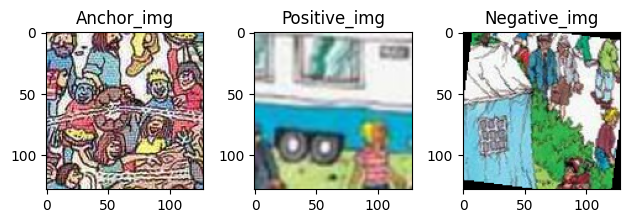

In [14]:
import matplotlib.pyplot as plt

# Assuming you have three tensors: image1, image2, image3
anchor_img, positive_img, negative_img, anchor_label = waldo_dataset.__getitem__(1309)

# Plotting the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.imshow(np.transpose(anchor_img, (1, 2, 0)))
plt.title('Anchor_img')

# Plotting the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.imshow(np.transpose(positive_img, (1, 2, 0)))
plt.title('Positive_img')

# Plotting the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.imshow(np.transpose(negative_img, (1, 2, 0)))
plt.title('Negative_img')

plt.tight_layout()  # To ensure proper spacing
plt.show()

# Split data into train-, validation- and testset

The used parameters are defined in the assignment

In [15]:
train_ratio = 0.81
val_ratio = 0.09
test_ratio = 0.1

tolerance = 1e-10
#we add this tolerance because of rounding errors in floating point arithmetic
if not(abs(train_ratio + val_ratio + test_ratio - 1) < tolerance):
    raise Exception("invalid train/val/test ratios")

total_length = len(waldo_dataset.imgs)
train_boundary = int(train_ratio * total_length)
validation_boundary = int((train_ratio + val_ratio) * total_length)

#split in train test and val set
train_set = WaldoTripletDataset.create_subset_dataset(waldo_dataset, 0, train_boundary)
val_set = WaldoTripletDataset.create_subset_dataset(waldo_dataset, train_boundary, validation_boundary)
test_set = WaldoTripletDataset.create_subset_dataset(waldo_dataset, validation_boundary, total_length)

#disable train on test and val
test_set.is_train = False

#some checks
print(f'Total Set:\nlength: {len(waldo_dataset.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(waldo_dataset.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {waldo_dataset.count_waldos()}\nwaldo percentage: {waldo_dataset.count_waldos() / len(waldo_dataset.imgs) * 100}\n')
print(f'TRAIN:\nlength: {len(train_set.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(train_set.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {train_set.count_waldos()}\nwaldo percentage: {train_set.count_waldos() / len(train_set.imgs) * 100}\n')
print(f'VALIDATION:\nlength: {len(val_set.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(val_set.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {val_set.count_waldos()}\nwaldo percentage: {val_set.count_waldos() / len(val_set.imgs) * 100}\n')
print(f'TEST:\nlength: {len(test_set.imgs)}. \nTotal length: {total_length}. \npercentage: {round(len(test_set.imgs) / total_length * 100.0, 2) / 100}\nwaldos: {test_set.count_waldos()}\nwaldo percentage: {test_set.count_waldos() / len(test_set.imgs) * 100}\n')


Total Set:
length: 6720. 
Total length: 6720. 
percentage: 1.0
waldos: 66
waldo percentage: 0.9821428571428571

TRAIN:
length: 5443. 
Total length: 6720. 
percentage: 0.81
waldos: 57
waldo percentage: 1.0472166084879662

VALIDATION:
length: 605. 
Total length: 6720. 
percentage: 0.09
waldos: 6
waldo percentage: 0.9917355371900827

TEST:
length: 672. 
Total length: 6720. 
percentage: 0.1
waldos: 3
waldo percentage: 0.4464285714285714



In [16]:

#we duplicate every waldo n times.
duplicate_factor = 100
WaldoTripletDataset.duplicate_waldos(train_set, duplicate_factor)

print(f'{waldo_percentage(train_set)}%')

51.66472224715067%


In [17]:
len(train_set.imgs)


11143

Define dataloaders

In [33]:
#creating DataLoader for each dataset
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

Model instantiation and testrun

In [34]:
model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)

random_input = torch.randn(1,3,128,128).to(device)
print(model(random_input).shape)

torch.Size([1, 2])


In [35]:
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = TripletLoss()

In [36]:
print_every = 20
def train(epoch):
  model.train()
  train_loss = 0
  positive_dis = 0
  negative_dis = 0
  total = 0
  for batch_idx, (anchor_imgs, positive_imgs, negative_imgs, anchor_labels) in enumerate(train_loader):
    anchor_imgs = anchor_imgs.to(device)
    positive_imgs = positive_imgs.to(device)
    negative_imgs = negative_imgs.to(device)

    optimizer.zero_grad()
    anchor_out = model(anchor_imgs)
    positive_out = model(positive_imgs)
    negative_out = model(negative_imgs)

    loss, positive, negative = criterion(anchor_out, positive_out, negative_out)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    epoch_loss = train_loss/(batch_idx+1)

    positive_dis += positive.item()
    negative_dis += negative.item()

    if batch_idx % print_every == 0:
        print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, positiv_dis: {:.3f}, negative_dis: {:.3f}'.format(epoch, epochs, batch_idx, len(train_loader), epoch_loss, positive_dis, negative_dis))
  return epoch_loss, positive_dis, negative_dis

In [37]:
def validation():
  model.eval()
  val_loss = 0
  val_positive_dis = 0
  val_negative_dis = 0
  correct = 0
  total = 0
  with torch.no_grad():
      for batch_idx, (anchor_imgs, positive_imgs, negative_imgs, label) in enumerate(tqdm(val_loader)):
        anchor_imgs = anchor_imgs.to(device)
        positive_imgs = positive_imgs.to(device)
        negative_imgs = negative_imgs.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_imgs)
        positive_out = model(positive_imgs)
        negative_out = model(negative_imgs)

        loss, positive, negative = criterion(anchor_out, positive_out, negative_out)

        val_loss += loss.item()
        val_positive_dis += positive.item()
        val_negative_dis += negative.item()

  loss = val_loss/(batch_idx+1)
  print('Val Loss: {:.3f}, positive distance: {:.3f}, negative distance: {:.3f}'.format(loss, positive, negative))
  return loss, val_positive_dis, val_negative_dis

In [38]:
losses = []
pos_distance = []
neg_distance = []

val_losses = []
val_pos_distance = []
val_neg_distance = []
for epoch in range(epochs):
    epoch_loss, positive_dis, negative_dis = train(epoch)

    train_results = []
    labels = []
    model.eval()

    losses.append(epoch_loss)
    pos_distance.append(positive_dis)
    neg_distance.append(negative_dis)
    scheduler.step()

    val_loss, val_positive_dis, val_negative_dis = validation()
    val_losses.append(val_loss)
    val_pos_distance.append(val_positive_dis)
    val_neg_distance.append(val_negative_dis)

    state = {'model': model.state_dict(),
             'loss' : val_loss,
             'epoch': epoch}

    torch.save(state, f'model.pth_{epoch}')

Epoch 0/50, Iter 0/88, Train Loss: 0.998, positiv_dis: 0.006, negative_dis: 0.007
Epoch 0/50, Iter 20/88, Train Loss: 0.967, positiv_dis: 4.494, negative_dis: 8.699
Epoch 0/50, Iter 40/88, Train Loss: 0.652, positiv_dis: 11.090, negative_dis: 53.259
Epoch 0/50, Iter 60/88, Train Loss: 0.489, positiv_dis: 15.704, negative_dis: 105.100
Epoch 0/50, Iter 80/88, Train Loss: 0.398, positiv_dis: 19.479, negative_dis: 157.785


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Val Loss: 0.092, positive distance: 0.164, negative distance: 2.462
Epoch 1/50, Iter 0/88, Train Loss: 0.106, positiv_dis: 0.160, negative_dis: 2.257
Epoch 1/50, Iter 20/88, Train Loss: 0.099, positiv_dis: 2.443, negative_dis: 43.049
Epoch 1/50, Iter 40/88, Train Loss: 0.096, positiv_dis: 4.430, negative_dis: 90.349
Epoch 1/50, Iter 60/88, Train Loss: 0.088, positiv_dis: 6.285, negative_dis: 136.153
Epoch 1/50, Iter 80/88, Train Loss: 0.087, positiv_dis: 8.360, negative_dis: 184.319


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Val Loss: 0.046, positive distance: 0.033, negative distance: 2.194
Epoch 2/50, Iter 0/88, Train Loss: 0.079, positiv_dis: 0.041, negative_dis: 2.085
Epoch 2/50, Iter 20/88, Train Loss: 0.077, positiv_dis: 1.789, negative_dis: 49.569
Epoch 2/50, Iter 40/88, Train Loss: 0.078, positiv_dis: 3.121, negative_dis: 85.162
Epoch 2/50, Iter 60/88, Train Loss: 0.076, positiv_dis: 4.515, negative_dis: 120.163
Epoch 2/50, Iter 80/88, Train Loss: 0.072, positiv_dis: 5.505, negative_dis: 152.807


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Val Loss: 0.037, positive distance: 0.021, negative distance: 1.959
Epoch 3/50, Iter 0/88, Train Loss: 0.072, positiv_dis: 0.064, negative_dis: 1.906
Epoch 3/50, Iter 20/88, Train Loss: 0.070, positiv_dis: 1.564, negative_dis: 37.611
Epoch 3/50, Iter 40/88, Train Loss: 0.066, positiv_dis: 2.839, negative_dis: 72.116
Epoch 3/50, Iter 60/88, Train Loss: 0.069, positiv_dis: 4.147, negative_dis: 103.009
Epoch 3/50, Iter 80/88, Train Loss: 0.067, positiv_dis: 5.424, negative_dis: 138.460


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Val Loss: 0.042, positive distance: 0.139, negative distance: 5.214
Epoch 4/50, Iter 0/88, Train Loss: 0.122, positiv_dis: 0.256, negative_dis: 5.052
Epoch 4/50, Iter 20/88, Train Loss: 0.061, positiv_dis: 1.831, negative_dis: 47.163
Epoch 4/50, Iter 40/88, Train Loss: 0.060, positiv_dis: 2.948, negative_dis: 80.257
Epoch 4/50, Iter 60/88, Train Loss: 0.058, positiv_dis: 3.970, negative_dis: 117.932
Epoch 4/50, Iter 80/88, Train Loss: 0.058, positiv_dis: 5.137, negative_dis: 152.493


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Val Loss: 0.109, positive distance: 0.160, negative distance: 2.485
Epoch 5/50, Iter 0/88, Train Loss: 0.090, positiv_dis: 0.082, negative_dis: 2.313
Epoch 5/50, Iter 20/88, Train Loss: 0.060, positiv_dis: 1.542, negative_dis: 37.962
Epoch 5/50, Iter 40/88, Train Loss: 0.056, positiv_dis: 2.778, negative_dis: 69.344
Epoch 5/50, Iter 60/88, Train Loss: 0.056, positiv_dis: 3.799, negative_dis: 96.389
Epoch 5/50, Iter 80/88, Train Loss: 0.055, positiv_dis: 4.973, negative_dis: 132.312


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Val Loss: 0.043, positive distance: 0.047, negative distance: 1.255
Epoch 6/50, Iter 0/88, Train Loss: 0.043, positiv_dis: 0.037, negative_dis: 1.244
Epoch 6/50, Iter 20/88, Train Loss: 0.054, positiv_dis: 1.290, negative_dis: 39.103
Epoch 6/50, Iter 40/88, Train Loss: 0.056, positiv_dis: 2.826, negative_dis: 79.408
Epoch 6/50, Iter 60/88, Train Loss: 0.056, positiv_dis: 4.229, negative_dis: 117.239
Epoch 6/50, Iter 80/88, Train Loss: 0.054, positiv_dis: 5.781, negative_dis: 155.573


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Val Loss: 0.197, positive distance: 0.032, negative distance: 0.867
Epoch 7/50, Iter 0/88, Train Loss: 0.181, positiv_dis: 0.029, negative_dis: 0.863
Epoch 7/50, Iter 20/88, Train Loss: 0.080, positiv_dis: 2.685, negative_dis: 76.815
Epoch 7/50, Iter 40/88, Train Loss: 0.074, positiv_dis: 4.486, negative_dis: 126.226
Epoch 7/50, Iter 60/88, Train Loss: 0.068, positiv_dis: 5.469, negative_dis: 160.310
Epoch 7/50, Iter 80/88, Train Loss: 0.064, positiv_dis: 6.348, negative_dis: 190.319


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Val Loss: 0.046, positive distance: 0.038, negative distance: 1.461
Epoch 8/50, Iter 0/88, Train Loss: 0.090, positiv_dis: 0.065, negative_dis: 1.444
Epoch 8/50, Iter 20/88, Train Loss: 0.055, positiv_dis: 0.963, negative_dis: 29.797
Epoch 8/50, Iter 40/88, Train Loss: 0.053, positiv_dis: 2.043, negative_dis: 62.753
Epoch 8/50, Iter 60/88, Train Loss: 0.050, positiv_dis: 3.188, negative_dis: 98.686
Epoch 8/50, Iter 80/88, Train Loss: 0.047, positiv_dis: 4.260, negative_dis: 136.844


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Loss: 0.039, positive distance: 0.092, negative distance: 2.513
Epoch 9/50, Iter 0/88, Train Loss: 0.053, positiv_dis: 0.074, negative_dis: 2.236
Epoch 9/50, Iter 20/88, Train Loss: 0.066, positiv_dis: 1.789, negative_dis: 46.251
Epoch 9/50, Iter 40/88, Train Loss: 0.057, positiv_dis: 3.296, negative_dis: 86.143
Epoch 9/50, Iter 60/88, Train Loss: 0.055, positiv_dis: 4.824, negative_dis: 122.114
Epoch 9/50, Iter 80/88, Train Loss: 0.055, positiv_dis: 6.023, negative_dis: 154.441


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Val Loss: 0.036, positive distance: 0.054, negative distance: 1.596
Epoch 10/50, Iter 0/88, Train Loss: 0.044, positiv_dis: 0.050, negative_dis: 1.551
Epoch 10/50, Iter 20/88, Train Loss: 0.042, positiv_dis: 1.089, negative_dis: 33.431
Epoch 10/50, Iter 40/88, Train Loss: 0.044, positiv_dis: 2.067, negative_dis: 67.217
Epoch 10/50, Iter 60/88, Train Loss: 0.042, positiv_dis: 3.478, negative_dis: 108.144
Epoch 10/50, Iter 80/88, Train Loss: 0.045, positiv_dis: 5.097, negative_dis: 151.064


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Val Loss: 0.038, positive distance: 0.069, negative distance: 2.169
Epoch 11/50, Iter 0/88, Train Loss: 0.116, positiv_dis: 0.105, negative_dis: 2.071
Epoch 11/50, Iter 20/88, Train Loss: 0.050, positiv_dis: 1.434, negative_dis: 36.740
Epoch 11/50, Iter 40/88, Train Loss: 0.048, positiv_dis: 2.687, negative_dis: 72.379
Epoch 11/50, Iter 60/88, Train Loss: 0.049, positiv_dis: 3.969, negative_dis: 109.739
Epoch 11/50, Iter 80/88, Train Loss: 0.049, positiv_dis: 5.754, negative_dis: 156.139


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Val Loss: 0.034, positive distance: 0.097, negative distance: 2.302
Epoch 12/50, Iter 0/88, Train Loss: 0.055, positiv_dis: 0.062, negative_dis: 1.975
Epoch 12/50, Iter 20/88, Train Loss: 0.039, positiv_dis: 1.599, negative_dis: 43.003
Epoch 12/50, Iter 40/88, Train Loss: 0.046, positiv_dis: 3.056, negative_dis: 84.061
Epoch 12/50, Iter 60/88, Train Loss: 0.048, positiv_dis: 4.419, negative_dis: 122.675
Epoch 12/50, Iter 80/88, Train Loss: 0.048, positiv_dis: 5.768, negative_dis: 165.929


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Val Loss: 0.026, positive distance: 0.055, negative distance: 1.806
Epoch 13/50, Iter 0/88, Train Loss: 0.051, positiv_dis: 0.056, negative_dis: 1.663
Epoch 13/50, Iter 20/88, Train Loss: 0.046, positiv_dis: 1.697, negative_dis: 46.930
Epoch 13/50, Iter 40/88, Train Loss: 0.050, positiv_dis: 3.626, negative_dis: 98.815
Epoch 13/50, Iter 60/88, Train Loss: 0.048, positiv_dis: 4.825, negative_dis: 135.497
Epoch 13/50, Iter 80/88, Train Loss: 0.048, positiv_dis: 6.680, negative_dis: 184.542


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Val Loss: 0.031, positive distance: 0.068, negative distance: 2.278
Epoch 14/50, Iter 0/88, Train Loss: 0.037, positiv_dis: 0.086, negative_dis: 2.221
Epoch 14/50, Iter 20/88, Train Loss: 0.044, positiv_dis: 1.832, negative_dis: 55.379
Epoch 14/50, Iter 40/88, Train Loss: 0.037, positiv_dis: 3.037, negative_dis: 95.456
Epoch 14/50, Iter 60/88, Train Loss: 0.035, positiv_dis: 4.966, negative_dis: 158.264
Epoch 14/50, Iter 80/88, Train Loss: 0.036, positiv_dis: 7.513, negative_dis: 220.546


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Loss: 0.020, positive distance: 0.056, negative distance: 2.333
Epoch 15/50, Iter 0/88, Train Loss: 0.049, positiv_dis: 0.067, negative_dis: 2.205
Epoch 15/50, Iter 20/88, Train Loss: 0.048, positiv_dis: 1.381, negative_dis: 38.954
Epoch 15/50, Iter 40/88, Train Loss: 0.042, positiv_dis: 2.845, negative_dis: 80.674
Epoch 15/50, Iter 60/88, Train Loss: 0.040, positiv_dis: 5.047, negative_dis: 130.006
Epoch 15/50, Iter 80/88, Train Loss: 0.041, positiv_dis: 6.871, negative_dis: 194.451


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Loss: 0.032, positive distance: 0.047, negative distance: 1.748
Epoch 16/50, Iter 0/88, Train Loss: 0.068, positiv_dis: 0.080, negative_dis: 1.670
Epoch 16/50, Iter 20/88, Train Loss: 0.047, positiv_dis: 1.791, negative_dis: 45.950
Epoch 16/50, Iter 40/88, Train Loss: 0.043, positiv_dis: 3.453, negative_dis: 93.244
Epoch 16/50, Iter 60/88, Train Loss: 0.043, positiv_dis: 5.299, negative_dis: 152.334
Epoch 16/50, Iter 80/88, Train Loss: 0.044, positiv_dis: 7.612, negative_dis: 215.987


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Val Loss: 0.038, positive distance: 0.146, negative distance: 3.652
Epoch 17/50, Iter 0/88, Train Loss: 0.048, positiv_dis: 0.117, negative_dis: 3.798
Epoch 17/50, Iter 20/88, Train Loss: 0.042, positiv_dis: 2.105, negative_dis: 54.433
Epoch 17/50, Iter 40/88, Train Loss: 0.039, positiv_dis: 3.774, negative_dis: 98.833
Epoch 17/50, Iter 60/88, Train Loss: 0.037, positiv_dis: 5.768, negative_dis: 146.739
Epoch 17/50, Iter 80/88, Train Loss: 0.038, positiv_dis: 7.433, negative_dis: 196.745


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Val Loss: 0.029, positive distance: 0.148, negative distance: 3.665
Epoch 18/50, Iter 0/88, Train Loss: 0.041, positiv_dis: 0.104, negative_dis: 3.588
Epoch 18/50, Iter 20/88, Train Loss: 0.045, positiv_dis: 1.975, negative_dis: 67.533
Epoch 18/50, Iter 40/88, Train Loss: 0.046, positiv_dis: 3.512, negative_dis: 107.400
Epoch 18/50, Iter 60/88, Train Loss: 0.044, positiv_dis: 5.198, negative_dis: 158.433
Epoch 18/50, Iter 80/88, Train Loss: 0.045, positiv_dis: 6.802, negative_dis: 203.765


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Val Loss: 0.035, positive distance: 0.048, negative distance: 1.610
Epoch 19/50, Iter 0/88, Train Loss: 0.057, positiv_dis: 0.045, negative_dis: 1.514
Epoch 19/50, Iter 20/88, Train Loss: 0.047, positiv_dis: 2.010, negative_dis: 56.824
Epoch 19/50, Iter 40/88, Train Loss: 0.042, positiv_dis: 4.454, negative_dis: 121.716
Epoch 19/50, Iter 60/88, Train Loss: 0.037, positiv_dis: 6.383, negative_dis: 177.092
Epoch 19/50, Iter 80/88, Train Loss: 0.035, positiv_dis: 7.981, negative_dis: 230.624


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Loss: 0.025, positive distance: 0.119, negative distance: 3.490
Epoch 20/50, Iter 0/88, Train Loss: 0.057, positiv_dis: 0.123, negative_dis: 3.140
Epoch 20/50, Iter 20/88, Train Loss: 0.029, positiv_dis: 1.723, negative_dis: 60.064
Epoch 20/50, Iter 40/88, Train Loss: 0.029, positiv_dis: 3.501, negative_dis: 117.971
Epoch 20/50, Iter 60/88, Train Loss: 0.030, positiv_dis: 5.188, negative_dis: 173.474
Epoch 20/50, Iter 80/88, Train Loss: 0.031, positiv_dis: 6.703, negative_dis: 227.936


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Val Loss: 0.093, positive distance: 0.183, negative distance: 1.778
Epoch 21/50, Iter 0/88, Train Loss: 0.040, positiv_dis: 0.099, negative_dis: 1.810
Epoch 21/50, Iter 20/88, Train Loss: 0.025, positiv_dis: 1.966, negative_dis: 57.347


KeyboardInterrupt: ignored

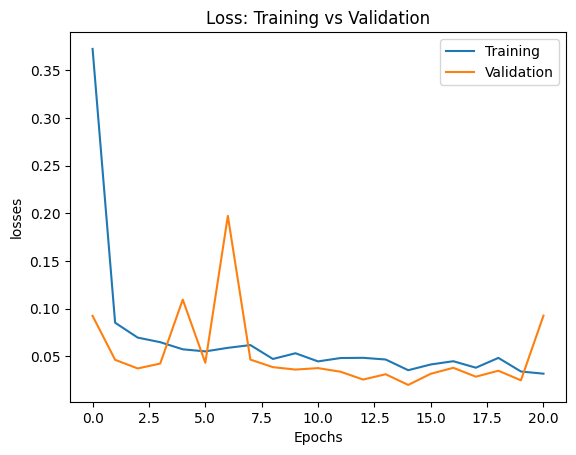

In [39]:
# Plotting the data
plt.plot(losses, label='Training')
plt.plot(val_losses, label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Loss: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

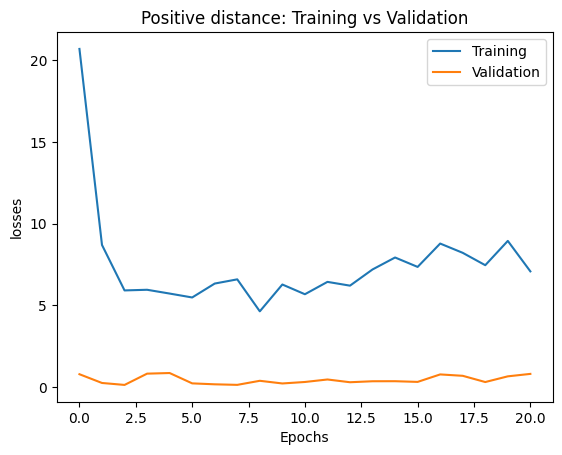

In [40]:
# Plotting the data
plt.plot(pos_distance, label='Training')
plt.plot(val_pos_distance, label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Positive distance: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

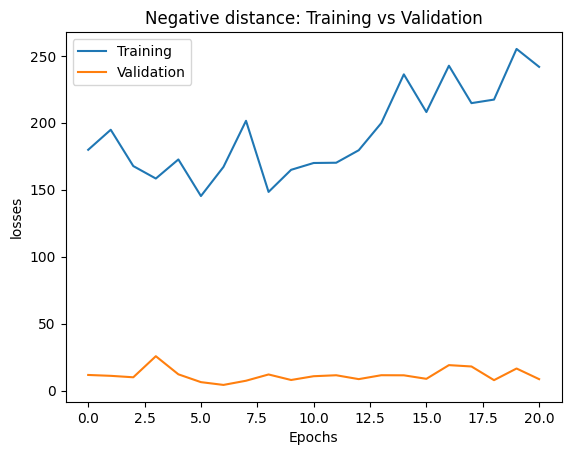

In [43]:
# Plotting the data
plt.plot(neg_distance, label='Training')
plt.plot(val_neg_distance, label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Negative distance: Training vs Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [44]:
model = ViT(image_size = 128,
            patch_size = 16,
            num_classes = 2,
            dim = 512,
            num_layers = 3,
            heads = 8,
            dropout = 0.1).to(device)
checkpoint = torch.load('/content/model.pth_12') #chose your figther
model.load_state_dict(checkpoint['model'])
model.eval()

ViT(
  (patchify): Patchify(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-2): 3 x ModuleList(
        (0): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (keys): Linear(in_features=512, out_features=512, bias=True)
          (values): Linear(in_features=512, out_features=512, bias=True)
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=512, out_features=2048, bias=True)
            (2): ReLU()
            (3): Dropout(p=0.1, inplace=False)
            (4): Linear(i

In [45]:
train_results = []
labels = []
model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(test_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


(672, 2)

In [ ]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
plt.legend()
plt.show()